In [1]:
import os
import cmdstanpy as stan
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import multiprocessing as mp
import pickle
import arviz as az
from scipy.special import expit

In [2]:
%load_ext stanmagic

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set() 

# Toy model

## Data

alpha-beta 0.020179150874782354 0.08480227036461345
alpha-beta 0.020138732820997488 0.14765993297111912
alpha-beta 0.011941885002441255 0.17524454386030702
alpha-beta 0.02148049838368843 0.15484514639221358
alpha-beta 0.032004018695016345 0.16758491060682984
alpha-beta 0.030102893273615806 0.13382899169827892
alpha-beta 0.026283362980314456 0.25455884389660427
alpha-beta 0.012715928240606106 0.15220691012941798
alpha-beta 0.051264685241349854 0.08897681542595567
alpha-beta 0.046622549368718555 0.14017065491085157
alpha-beta 0.009856701205930183 0.23456943905159855
alpha-beta 0.025000734559710316 0.13270185689122133
alpha-beta 0.030471556913343984 0.13118707341806754
alpha-beta 0.025069606725083193 0.0938853006083876
alpha-beta 0.017830566922956266 0.07141227489370501
alpha-beta 0.00828553396167151 0.15350814990272157
alpha-beta 0.018020619947436943 0.10642769749594708
alpha-beta 0.013770200282508777 0.06996704466048559
alpha-beta 0.0164886483430051 0.11853567773591532
alpha-beta 0.0154

[]

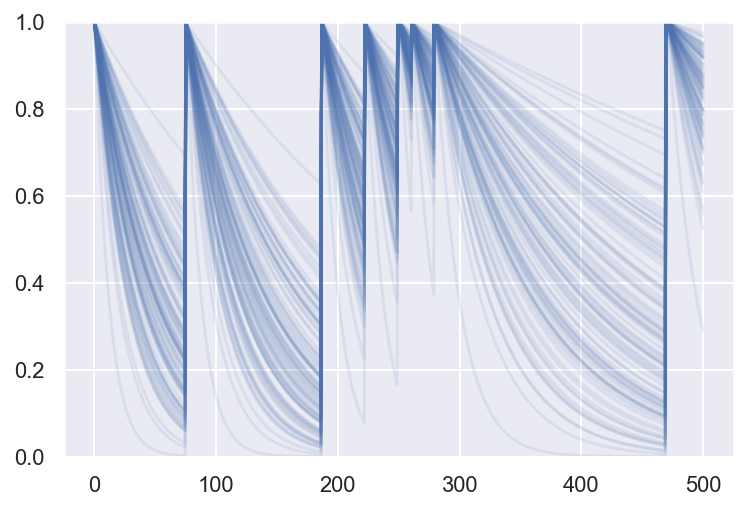

In [4]:
theta1 = np.random.normal(-4, 0.5, size=100)
theta2 = np.random.normal(-2, 0.4, size=100)

max_t = 5* 10**2
n_pres = 10

x = np.linspace(0, max_t, 1000)
pres = np.concatenate(([0,], np.sort(np.random.uniform(0, max_t, n_pres-1))))

n = np.zeros(x.shape)

delta = np.zeros(x.shape)
for i, p in enumerate(pres):
    delta[x>p] = x[x>p] - p
    n[x>p] = i
fig, ax = plt.subplots()

for th1, th2 in zip(theta1, theta2):
    alpha, beta = np.exp(th1), expit(th2)
    print("alpha-beta", alpha, beta)
    p = np.exp(-alpha*(1-beta)**n*delta)
    ax.plot(x, p, color='C0', alpha=0.1)
ax.set_ylim(0, 1)
plt.plot()

In [5]:
# Seed
np.random.seed(123)


sg_u = 0.1, 0.1
sg_w = 0.5, 0.3

sg_theta = (0.001, 0.001)

mu = (-4, 0.3)
n_param = 2

# Number of users
n_u = 20
# Number of words
n_w = 10
# Number of obs
n_o = 10

# Generate data
U = np.random.normal(0, sg_u, size=(n_u, n_param))   # User ability
W = np.random.normal(0, sg_w, size=(n_w, n_param))   # Item difficulty

shape = (n_w, n_u, n_o)

delta = np.random.uniform(0, 100, size=shape)
n_rep = np.zeros(shape=shape, dtype=int)
n_rep[:] = np.tile(np.arange(n_o), (n_w, n_u, 1))

rd = np.random.random(size=shape)

y = np.zeros(shape=shape, dtype=int)
theta = np.zeros(shape=(n_param, ) + shape)

for w in range(n_w):
    for u in range(n_u):
        theta[:,w,u,:] = np.tile(np.random.normal(mu + U[u] + W[w], sg_theta), (n_o, 1)).T


a = np.exp(theta[0])
b = expit(theta[1])

exponent = - a *(1-b)**n_rep * delta
p = np.exp(exponent)
y[:] = p > rd
        
data = {'n': n_w*n_o*n_u, 'n_u': n_u, 'n_w': n_w,  'n_o': n_o, 'delta': delta, 'n_rep': n_rep, 'y': y}

In [6]:
print(np.mean(p), np.max(p), np.min(p))
print(np.mean(y), np.min(y), np.max(y))

0.8693586884909223 0.9999999704836393 0.0023537009407409424
0.8715 0 1


# Model

In [7]:
%%stan -f model2param.stan -v model2param --stanc ~/.cmdstan/cmdstan-2.26.1/bin/stanc
data {
  int<lower=0> n_u;  // Number of users    
  int<lower=0> n_w;  // Number of words
  int<lower=0> n_o;  // Number of observations
  int<lower=0> n;
  real delta[n_w, n_u, n_o];
  int n_rep[n_w, n_u, n_o];
  int y[n_w, n_u, n_o];
}
transformed data {
  vector[n] n_rep_arr;
  vector[n] delta_arr;
  int y_arr[n];
  
  n_rep_arr = to_vector(to_array_1d(n_rep));
  delta_arr = to_vector(to_array_1d(delta));
  y_arr = to_array_1d(y);
}
parameters {
  real<lower=0> sg_u1;
  real<lower=0> sg_w1;
  real<lower=0> sg_theta1;
  real mu1;
  real<lower=0> sg_u2;
  real<lower=0> sg_w2;
  real<lower=0> sg_theta2;
  real mu2;
  
  real U1[n_u];
  real W1[n_w];
  real theta1_wu[n_w, n_u];
  real U2[n_u];
  real W2[n_w];
  real theta2_wu[n_w, n_u];
}
model {
  real theta1[n_w, n_u, n_o];
  vector[n] theta1_arr;
  real theta2[n_w, n_u, n_o];
  vector[n] theta2_arr;
  vector[n] a;
  vector[n] b;
  vector[n] rate;
  vector[n] exponent;
  vector[n] p;
  
  sg_w1 ~ inv_gamma(1, 1);
  sg_u1 ~ inv_gamma(1, 1);
  sg_theta1 ~ inv_gamma(1, 1);
  mu1 ~ normal(0, 10);
  U1 ~ normal(0, sg_u1);
  W1 ~ normal(0, sg_w1);
  
  sg_w2 ~ inv_gamma(1, 1);
  sg_u2 ~ inv_gamma(1, 1);
  sg_theta2 ~ inv_gamma(1, 1);
  mu2 ~ normal(0, 10);
  U2 ~ normal(0, sg_u2);
  W2 ~ normal(0, sg_w2);

  for (u in 1:n_u) {
    for (w in 1:n_w) {
      theta1_wu[w, u] ~ normal(mu1 + U1[u] + W1[w], sg_theta1);
      theta1[w, u] = to_array_1d(rep_vector(theta1_wu[w, u], n_o)); 
      theta2_wu[w, u] ~ normal(mu2 + U2[u] + W2[w], sg_theta2);
      theta2[w, u] = to_array_1d(rep_vector(theta2_wu[w, u], n_o)); 
    }
  }
  
  theta1_arr = to_vector(to_array_1d(theta1));
  theta2_arr = to_vector(to_array_1d(theta2));
  a = exp(theta1_arr);
  b = inv_logit(theta2_arr);
  exponent = - a .* pow(1-b, n_rep_arr) .* delta_arr;
  p = exp(exponent);
  y_arr ~ bernoulli(p);
}

Using stanc compiler:  ~/.cmdstan/cmdstan-2.26.1/bin/stanc
~/.cmdstan/cmdstan-2.26.1/bin/stanc --o=/var/folders/yg/spp3n_c56vxbgvjy9wthwy_h0000gn/T/0f0148a5-aa25-4e03-98c3-b9facab95136.cpp model2param.stan

-------------------------------------------------------------------------------
Model compiled successfully. Output stored in model2param object.
Type model2param in a cell to see a nicely formatted code output in a notebook
     ^^^^^^^^^^^
Access model compile output properties
model2param.model_file -> Name of stan_file [model2param.stan]
model2param.model_name -> Name of stan model [model2param_model]
model2param.model_code -> Model code [data {   int<lower=0 ....]


In [8]:
m = stan.CmdStanModel(stan_file=model2param.model_file)

INFO:cmdstanpy:compiling stan program, exe file: /Users/aureliennioche/Documents/PythonProjects/ActiveTeachingCollaborative/model2param
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/aureliennioche/Documents/PythonProjects/ActiveTeachingCollaborative/model2param


In [9]:
trace = m.sample(data=data, show_progress="notebook")

Chain 1 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 2 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 3 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 4 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
az.plot_trace(trace, var_names=['mu1', 'sg_w1', 'sg_u1', 'mu2', 'sg_w2', 'sg_u2']);

## MLE

In [97]:
%%time
mp = m.optimize(data=data, algorithm='BFGS', seed=1)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


CPU times: user 9.56 ms, sys: 15.7 ms, total: 25.3 ms
Wall time: 16.7 s


In [98]:
for var in 'mu1', 'sg_w1', 'sg_u1', 'mu2', 'sg_w2', 'sg_u2':
    print(var, mp.optimized_params_dict[var])

mu1 -3.71732
sg_w1 0.524009
sg_u1 0.0462797
mu2 0.398964
sg_w2 0.137825
sg_u2 0.0462345
